### Quantifying PAR-2 membrane binding cooperativity

Context:
- Using membrane and cytoplasm measurements is cells with varying levels of PAR-2 to quantify cooperativity

Results:
- For wild type, the cooperativity score is ~2 (quadratic relationship)
- For RING mutants (C56S, L109R) the score is reduced
- These relationships hold whether looking at polarised cells, uniform cells, or aggregating both

Dependencies:
- Relies on quantification data generated using _Run/par2_nebd_quantify.ipynb_

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib.legend_handler import HandlerTuple

from src import (
    ExponentConfidenceInterval,
    add_stats_table_row,
    bounded_mean_1d,
    fake_log,
    lighten,
    minor_ticks,
    nb_setup,
    random_grouped_scatter,
)

nb_setup()
os.makedirs("Figs", exist_ok=True)
os.makedirs("../../../data/EMBO_source_data", exist_ok=True)

%matplotlib inline

### Import data, summarise quantification

In [2]:
# Import data
df = pd.read_csv("../../../data/par2_nebd_embryos.csv")
df_quantification = pd.read_csv("../../../data/par2_nebd_quantification.csv")

# Filter relevant data
lines = ["lp637", "nwg201", "nwg240", "nwg246", "nwg338", "nwg369"]
df = df[df.Line.isin(lines)]
df_quantification = df_quantification[df_quantification.EmbryoID.isin(df.EmbryoID)]


# Summary quantification
def calculate_summary(group):
    cyt = group["Cytoplasmic signal"].mean()
    mem_tot = group["Membrane signal"].mean()
    mem_ant = bounded_mean_1d(group["Membrane signal"], [0.4, 0.6])
    mem_post = bounded_mean_1d(group["Membrane signal"], [0.9, 0.1])
    return pd.Series(
        {
            "Cyt": cyt,
            "Mem_tot": mem_tot,
            "Mem_ant": mem_ant,
            "Mem_post": mem_post,
        }
    )


df_summary = (
    df_quantification.groupby("EmbryoID").apply(calculate_summary).reset_index()
)
df = pd.merge(df, df_summary, on="EmbryoID")

# Add uniform vs polarised column
unipol_dict = {
    line: "Pol" if line in ["lp637", "nwg240", "nwg338"] else "Uni" for line in lines
}
df["UniPol"] = df["Line"].map(unipol_dict)

# Add genotype column
genotype_dict = {
    "lp637": "WT",
    "nwg201": "WT",
    "nwg240": "C56S",
    "nwg246": "C56S",
    "nwg338": "L109R",
    "nwg369": "L109R",
    # "nwg376": "GCN4",
    # "nwg437": "GCN4",
}
df["Genotype"] = df["Line"].map(genotype_dict)

# # Remove points below threshold
# mem_thresh = 4e2
# cyt_thresh = 2e2
# df = df[df.Mem_post > mem_thresh]
# df = df[df.Cyt > cyt_thresh]

### Analysis

In [3]:
analysisWT_pooled = ExponentConfidenceInterval(df[df.Line.isin(["lp637", "nwg201"])])
analysisC56S_pooled = ExponentConfidenceInterval(df[df.Line.isin(["nwg240", "nwg246"])])
analysisL109R_pooled = ExponentConfidenceInterval(
    df[df.Line.isin(["nwg338", "nwg369"])]
)
# analysisGCN4_pooled = ExponentConfidenceInterval(df[df.Line.isin(["nwg376", "nwg437"])])

analysisWT_polarised = ExponentConfidenceInterval(df[df.Line.isin(["lp637"])])
analysisC56S_polarised = ExponentConfidenceInterval(df[df.Line.isin(["nwg240"])])
analysisL109R_polarised = ExponentConfidenceInterval(df[df.Line.isin(["nwg338"])])
# analysisGCN4_polarised = ExponentConfidenceInterval(df[df.Line.isin(["nwg376"])])

analysisWT_uniform = ExponentConfidenceInterval(df[df.Line.isin(["nwg201"])])
analysisC56S_uniform = ExponentConfidenceInterval(df[df.Line.isin(["nwg246"])])
analysisL109R_uniform = ExponentConfidenceInterval(df[df.Line.isin(["nwg369"])])
# analysisGCN4_uniform = ExponentConfidenceInterval(df[df.Line.isin(["nwg437"])])

analysisWT_uniform2 = ExponentConfidenceInterval(
    df[df.Line.isin(["nwg201"])], whole_embryo=True
)
analysisC56S_uniform2 = ExponentConfidenceInterval(
    df[df.Line.isin(["nwg246"])], whole_embryo=True
)
analysisL109R_uniform2 = ExponentConfidenceInterval(
    df[df.Line.isin(["nwg369"])], whole_embryo=True
)
# analysisGCN4_uniform2 = ExponentConfidenceInterval(
#     df[df.Line.isin(["nwg437"])], whole_embryo=True
# )

### Plotting functions

In [4]:
def plot_rundown_ci(ax, res, color):
    ax.plot(res.res_x, res.res_y, c="k", zorder=100, linewidth=1)
    ax.fill_between(
        res.res_x,
        res.all_fits_lower,
        res.all_fits_upper,
        alpha=0.1,
        color="k",
        zorder=100,
    )
    ax.set_xlabel("Cytoplasmic conc. (a.u.)", fontsize=9)
    ax.set_ylabel("Membrane conc. (a.u.)", fontsize=9)
    ax.tick_params(axis="both", labelsize=8)
    b = np.array([r == "Pol" for r in res.unipol])
    r = random_grouped_scatter()
    r.add(res.cyts[~b], res.mems[~b], color=lighten(color))
    r.add(res.cyts[b], res.mems[b], color=color)
    r.plot(ax)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    for i in np.arange(-10, 10, 0.5):
        ax.plot([-10, 10], [i - 10, i + 10], c="0.9", zorder=-100, linewidth=1)
    ax.set_xticks(np.arange(0, 10))
    ax.set_yticks(np.arange(0, 10))
    minor_ticks(ax, [0, 10], [0, 10])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.xaxis.set_major_formatter(fake_log)
    ax.yaxis.set_major_formatter(fake_log)


def violin(ax, res, xpos, color):
    # Create KDE and x-axis values
    kde = st.gaussian_kde(res.exponents)
    xx = np.linspace(min(res.exponents), max(res.exponents), 1000)
    kde_xx = kde(xx) / max(kde(xx))

    # Plot violin
    ax.fill_betweenx(xx, xpos - 0.8 * kde_xx, xpos + 0.8 * kde_xx, color=color)

    # Plot percentile lines
    percentiles = np.percentile(res.exponents, [2.5, 97.5])
    ax.plot([xpos, xpos], percentiles, c="k", linewidth=0.5)

    # Plot scatter
    ax.scatter(xpos, res.exponent_full, c="k", s=5)

### Full figure

In [5]:
def full_figure(analysisWT, analysisC56S, analysisL109R):
    # Create figure
    fig, ax = plt.subplots(1, 4)

    # Analysis and colors for each plot
    analyses = [analysisWT, analysisC56S, analysisL109R]
    colors = ["tab:blue", "tab:orange", "tab:green"]

    # Rundown plots
    for i in range(3):
        plot_rundown_ci(ax[i], analyses[i], colors[i])
        ax[i].set_ylim(2, 5)
        ax[i].set_aspect("equal", adjustable="datalim")

    # Violin plot
    violin(ax[3], analysisWT, 1, "tab:blue")
    violin(ax[3], analysisC56S, 3, "tab:orange")
    violin(ax[3], analysisL109R, 5, "tab:green")

    # Equation
    ax[0].plot([], [], c="k", linewidth=1, label=r"$y = \beta x^\alpha$")
    ax[0].legend(frameon=False, fontsize=8, loc="lower right")

    # Tidy violin plot
    ax[3].set_xticks([1, 3, 5])
    ax[3].set_xticklabels(["WT", "C56S", "L109R"])
    for tick in ax[3].get_xticklabels():
        tick.set_rotation(45)
        tick.set_horizontalalignment("right")
    ax[3].set_ylabel("Cooperativity (α)")
    ax[3].tick_params(axis="both", labelsize=8)
    ax[3].set_ylim()
    ax[3].axhline(1, color="k", linestyle="--", zorder=-100, linewidth=1)

    # Tidy figure
    fig.set_size_inches(10, 2.8)
    fig.subplots_adjust(left=0.08, wspace=0.6, bottom=0.3, right=0.95)
    return fig, ax

### Rundown plots

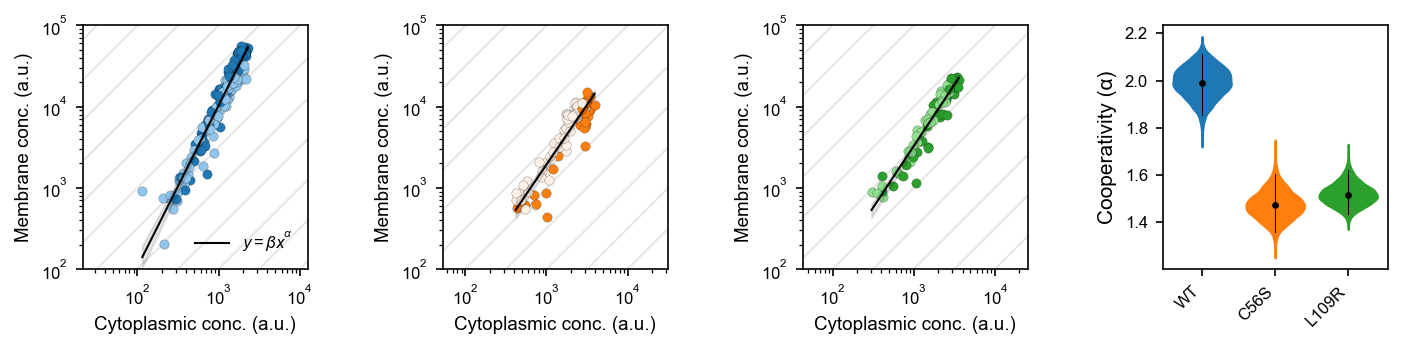

In [6]:
# Pooled
fig, ax = full_figure(analysisWT_pooled, analysisC56S_pooled, analysisL109R_pooled)
fig.savefig("Figs/log_ols_pooled.png", dpi=600, transparent=True)
fig.savefig("Figs/log_ols_pooled.pdf", transparent=True)

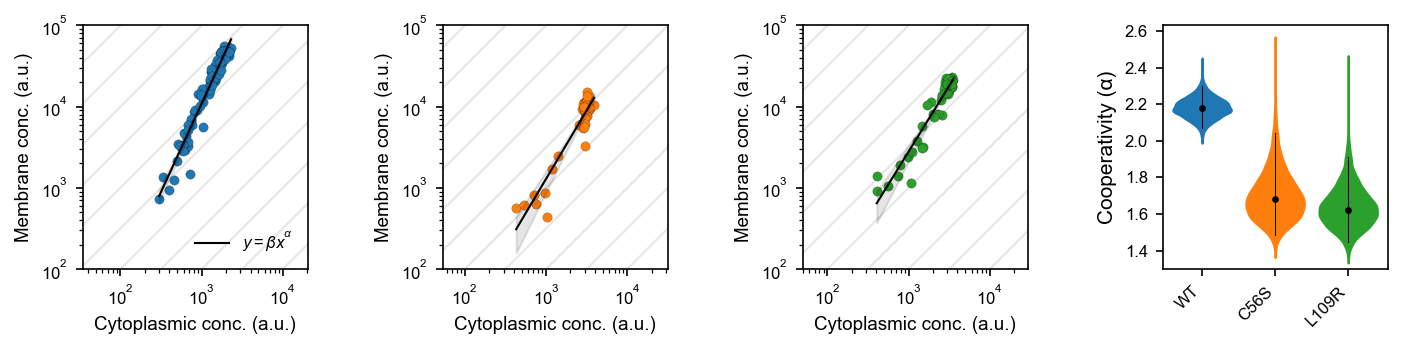

In [7]:
# Polarised
fig, ax = full_figure(
    analysisWT_polarised, analysisC56S_polarised, analysisL109R_polarised
)
ax[3].set_ylim(bottom=1.3)
fig.savefig("Figs/log_ols_polarised.png", dpi=600, transparent=True)
fig.savefig("Figs/log_ols_polarised.pdf", transparent=True)

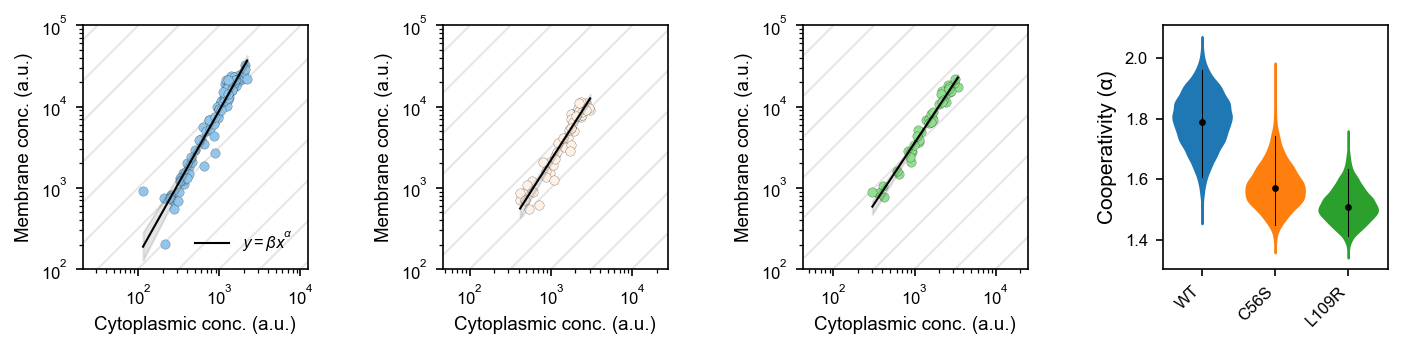

In [8]:
# Uniform
fig, ax = full_figure(analysisWT_uniform, analysisC56S_uniform, analysisL109R_uniform)
fig.savefig("Figs/log_ols_uniform.png", dpi=600, transparent=True)
fig.savefig("Figs/log_ols_uniform.pdf", transparent=True)

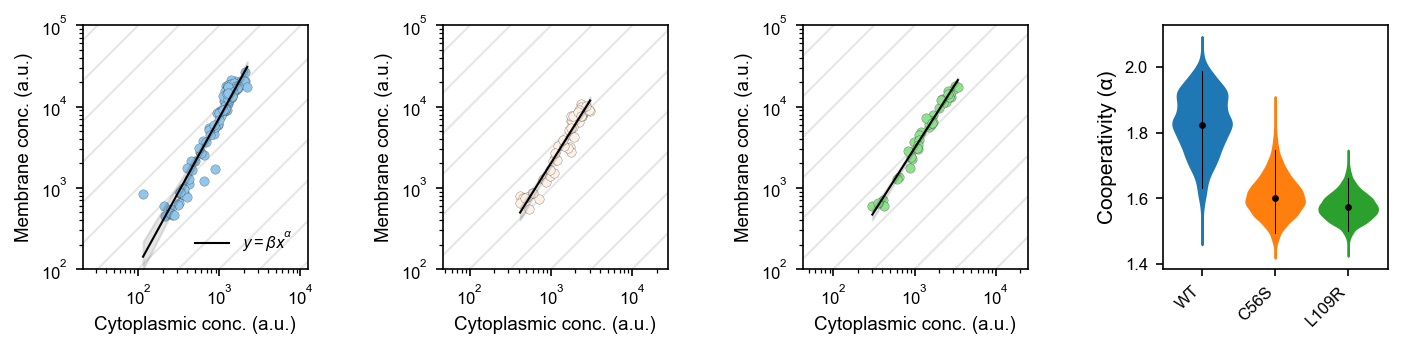

In [9]:
# Uniform (whole embryo)
fig, ax = full_figure(
    analysisWT_uniform2, analysisC56S_uniform2, analysisL109R_uniform2
)
fig.savefig("Figs/log_ols_uniform_whole_embryo.png", dpi=600, transparent=True)
fig.savefig("Figs/log_ols_uniform_whole_embryo.pdf", transparent=True)

### Rundown plots (wt and mutants combined)

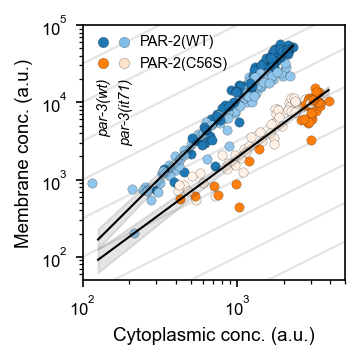

In [10]:
# Analysis
analysisWT = ExponentConfidenceInterval(df[df.Line.isin(["lp637", "nwg201"])], xmin=2.1)
analysisC56S = ExponentConfidenceInterval(
    df[df.Line.isin(["nwg240", "nwg246"])], xmin=2.1
)

# Create figure
fig, ax = plt.subplots()
plot_rundown_ci(ax, analysisWT, "tab:blue")
plot_rundown_ci(ax, analysisC56S, "tab:orange")

# Legend
s = 25
top_left = ax.scatter([], [], linewidth=0.1, edgecolors="k", color="tab:blue", s=s)
bottom_left = ax.scatter([], [], linewidth=0.1, edgecolors="k", color="tab:orange", s=s)
top_right = ax.scatter(
    [], [], linewidth=0.1, edgecolors="k", color=lighten("tab:blue", 1.7), s=s
)
bottom_right = ax.scatter(
    [], [], linewidth=0.1, edgecolors="k", color=lighten("tab:orange", 1.7), s=s
)
ax.legend(
    [(top_left, top_right), (bottom_left, bottom_right)],
    ["PAR-2(WT)", "PAR-2(C56S)"],
    fontsize=7,
    handler_map={tuple: HandlerTuple(ndivide=None, pad=1)},
    loc=(0.04, 0.8),
    frameon=False,
)
ax.text(
    x=0.055,
    y=0.79,
    s="par-3(wt)",
    ha="left",
    va="top",
    rotation=90,
    transform=ax.transAxes,
    fontsize=7,
    fontstyle="italic",
)
ax.text(
    x=0.14,
    y=0.79,
    s="par-3(it71)",
    ha="left",
    va="top",
    rotation=90,
    transform=ax.transAxes,
    fontsize=7,
    fontstyle="italic",
)

# Finalise figure
ax.set_xlim(2, 3.7)
ax.set_ylim(1.7, 5)
fig.set_size_inches(2.5, 2.5)
fig.subplots_adjust(left=0.2, bottom=0.2)

# Save figure
fig.savefig("Figs/for_paper_c56s_rundown.png", dpi=600, transparent=True)
fig.savefig("Figs/for_paper_c56s_rundown.pdf", transparent=True)

# SourceData
_df = df[df.Line.isin(["lp637", "nwg201", "nwg240", "nwg246"])]
_df.to_csv("../../../data/EMBO_source_data/1G.csv", index=False)

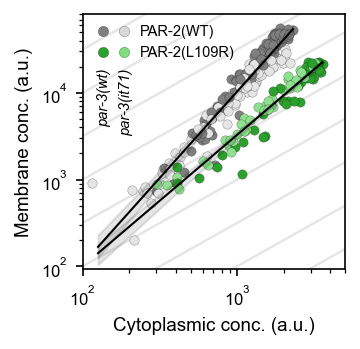

In [11]:
# Analysis
analysisWT = ExponentConfidenceInterval(df[df.Line.isin(["lp637", "nwg201"])], xmin=2.1)
analysisL109R = ExponentConfidenceInterval(
    df[df.Line.isin(["nwg338", "nwg369"])], xmin=2.1
)

# Create figure
fig, ax = plt.subplots()
plot_rundown_ci(ax, analysisWT, "tab:gray")
plot_rundown_ci(ax, analysisL109R, "tab:green")

# Legend
s = 25
top_left = ax.scatter([], [], linewidth=0.1, edgecolors="k", color="tab:gray", s=s)
bottom_left = ax.scatter([], [], linewidth=0.1, edgecolors="k", color="tab:green", s=s)
top_right = ax.scatter(
    [], [], linewidth=0.1, edgecolors="k", color=lighten("tab:gray", 1.7), s=s
)
bottom_right = ax.scatter(
    [], [], linewidth=0.1, edgecolors="k", color=lighten("tab:green", 1.7), s=s
)
ax.legend(
    [(top_left, top_right), (bottom_left, bottom_right)],
    ["PAR-2(WT)", "PAR-2(L109R)"],
    fontsize=7,
    handler_map={tuple: HandlerTuple(ndivide=None, pad=1)},
    loc=(0.04, 0.8),
    frameon=False,
)
ax.text(
    x=0.055,
    y=0.79,
    s="par-3(wt)",
    ha="left",
    va="top",
    rotation=90,
    transform=ax.transAxes,
    fontsize=7,
    fontstyle="italic",
)
ax.text(
    x=0.14,
    y=0.79,
    s="par-3(it71)",
    ha="left",
    va="top",
    rotation=90,
    transform=ax.transAxes,
    fontsize=7,
    fontstyle="italic",
)

# Finalise figure
ax.set_xlim(2, 3.7)
fig.set_size_inches(2.5, 2.5)
fig.subplots_adjust(left=0.2, bottom=0.2)

# Save figure
fig.savefig("Figs/for_paper_l109r_rundown.png", dpi=600, transparent=True)
fig.savefig("Figs/for_paper_l109r_rundown.pdf", transparent=True)

# SourceData
_df = df[df.Line.isin(["lp637", "nwg201", "nwg338", "nwg369"])]
_df.to_csv("../../../data/EMBO_source_data/2J.csv", index=False)

### Violin plots

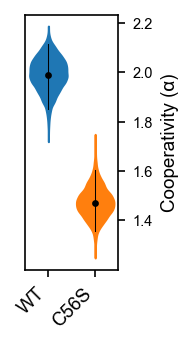

In [12]:
fig, ax = plt.subplots(1)

violin(ax, analysisWT_pooled, 1, "tab:blue")
violin(ax, analysisC56S_pooled, 3, "tab:orange")

ax.set_xticks([1, 3])
ax.set_xticklabels(["WT", "C56S"])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")
ax.set_ylabel("Cooperativity (α)", fontsize=9)
ax.tick_params(axis="y", labelsize=7)
ax.tick_params(axis="x", labelsize=9)
ax.set_ylim()
ax.axhline(1, color="k", linestyle="--", zorder=-100, linewidth=1)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

fig.set_size_inches(1.3, 2.5)
fig.subplots_adjust(bottom=0.2, right=0.6)
fig.savefig("Figs/for_paper_exponents.png", dpi=600, transparent=True)
fig.savefig("Figs/for_paper_exponents.pdf", transparent=True)

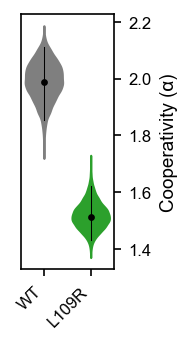

In [13]:
fig, ax = plt.subplots(1)

violin(ax, analysisWT_pooled, 1, "tab:gray")
violin(ax, analysisL109R_pooled, 3, "tab:green")

ax.set_xticks([1, 3])
ax.set_xticklabels(["WT", "L109R"])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")
ax.set_ylabel("Cooperativity (α)", fontsize=9)
ax.tick_params(axis="both", labelsize=8)
ax.set_ylim()
ax.axhline(1, color="k", linestyle="--", zorder=-100, linewidth=1)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

fig.set_size_inches(1.3, 2.5)
fig.subplots_adjust(bottom=0.2, right=0.6)
fig.savefig("Figs/for_paper_exponents_l109r.png", dpi=600, transparent=True)
fig.savefig("Figs/for_paper_exponents_l109r.pdf", transparent=True)

### Effect sizes

In [14]:
# Fig 1: Effect of WT vs C56S (pooled)
es = analysisC56S_pooled.exponent_full - analysisWT_pooled.exponent_full
pr = analysisC56S_pooled.exponents - analysisWT_pooled.exponents
ss = (len(analysisWT_pooled.mems), len(analysisC56S_pooled.mems))
add_stats_table_row(
    figure="1",
    panel="G",
    sample_a="PAR-2(WT)",
    sample_b="PAR-2(C56S)",
    measure="Cooperativity",
    effect_size=es,
    probability_distribution=pr,
    sample_size=ss,
    key="EoNvB1UKsp",
)

# Fig 2: Effect of WT vs C56S (pooled)
es = analysisL109R_pooled.exponent_full - analysisWT_pooled.exponent_full
pr = analysisL109R_pooled.exponents - analysisWT_pooled.exponents
ss = (len(analysisWT_pooled.mems), len(analysisL109R_pooled.mems))
add_stats_table_row(
    figure="2",
    panel="J",
    sample_a="PAR-2(WT)",
    sample_b="PAR-2(L109R)",
    measure="Cooperativity",
    effect_size=es,
    probability_distribution=pr,
    sample_size=ss,
    key="8cNzrmowUR",
)

# Fig EV1: Effect of WT vs C56S (polarised)
es = analysisC56S_polarised.exponent_full - analysisWT_polarised.exponent_full
pr = analysisC56S_polarised.exponents - analysisWT_polarised.exponents
ss = (len(analysisWT_polarised.mems), len(analysisC56S_polarised.mems))
add_stats_table_row(
    figure="EV1",
    panel="D",
    sample_a="PAR-2(WT); par-3(wt)",
    sample_b="PAR-2(C56S); par-3(wt)",
    measure="Cooperativity",
    effect_size=es,
    probability_distribution=pr,
    sample_size=ss,
    key="fjwQPEmbv7",
)

# Fig EV1: Effect of WT vs L109R (polarised)
es = analysisL109R_polarised.exponent_full - analysisWT_polarised.exponent_full
pr = analysisL109R_polarised.exponents - analysisWT_polarised.exponents
ss = (len(analysisWT_polarised.mems), len(analysisL109R_polarised.mems))
add_stats_table_row(
    figure="EV1",
    panel="D",
    sample_a="PAR-2(WT); par-3(wt)",
    sample_b="PAR-2(L109R); par-3(wt)",
    measure="Cooperativity",
    effect_size=es,
    probability_distribution=pr,
    sample_size=ss,
    key="rV1Pgo39TS",
)

# Fig EV1: Effect of WT vs C56S (uniform)
es = analysisC56S_uniform.exponent_full - analysisWT_uniform.exponent_full
pr = analysisC56S_uniform.exponents - analysisWT_uniform.exponents
ss = (len(analysisWT_uniform.mems), len(analysisC56S_uniform.mems))
add_stats_table_row(
    figure="EV1",
    panel="F",
    sample_a="PAR-2(WT); par-3(it71)",
    sample_b="PAR-2(C56S); par-3(it71)",
    measure="Cooperativity",
    effect_size=es,
    sample_size=ss,
    probability_distribution=pr,
    key="QAXlo1N17N",
)

# Fig EV1: Effect of WT vs L109R (uniform)
es = analysisL109R_uniform.exponent_full - analysisWT_uniform.exponent_full
pr = analysisL109R_uniform.exponents - analysisWT_uniform.exponents
ss = (len(analysisWT_uniform.mems), len(analysisL109R_uniform.mems))
add_stats_table_row(
    figure="EV1",
    panel="F",
    sample_a="PAR-2(WT); par-3(it71)",
    sample_b="PAR-2(L109R); par-3(it71)",
    measure="Cooperativity",
    effect_size=es,
    probability_distribution=pr,
    sample_size=ss,
    key="mzzAUPa4Rl",
)